# Обучение без учителя
## метод главных компонент(PCA), кластеризация.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy import sparse
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from scipy.sparse.csgraph._validation import validate_graph
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from sklearn.utils import check_array
from sklearn.datasets import make_blobs,make_moons
from sklearn.cluster import KMeans,AgglomerativeClustering, DBSCAN,AffinityPropagation
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances, adjusted_rand_score, accuracy_score, adjusted_mutual_info_score, v_measure_score, silhouette_score


from sklearn.decomposition import PCA

# функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

from ipywidgets import interact
from IPython.display import display
import ipywidgets as widgets
import mglearn

# Кластеризация

**Задача кластеризации** (или обучения без учителя) заключается в следующем - имеется обучающая выборка $X^l = \{x_1, . . . , x_l\}\subset X$ и функция расстояния между объектами $\rho(x, x')$. Требуется разбить выборку на непересекающиеся подмножества, называемые кластерами, так, чтобы каждый кластер состоял из объектов, близких по метрике $\rho$, а объекты разных кластеров существенно отличались. При этом каждому объекту $x_i \in X_l$ приписывается метка (номер) кластера $y_i$.

Кластеризация- это задача класса **обучения без учителя**. 

Задача обучения без учителя отличается от задачи обучения с учителем тем, что метки исходных объектов $y_i$ изначально не заданы, и даже может быть неизвестно само множество $Y$.

Или другими словами. 
У нас есть какие-то объекты, эти объекты по тем или другим характеристикам похожи между собой. Благодаря этим характеристикам наши объекты можно разбить на группы, кластера, так что объекты в разных группах будут не похожи. Так же в случае появления нового объекта мы должны уметь его отнести к той или иной группе.

## Похожесть объектов
Как же определять «похожесть» объектов? 

Нужно составить вектор характеристик для каждого объекта — как правило это набор числовых значений, например, длина-ширина-высота объекта.

Так же стоит помнить что во многих прикладных задачах измерять степень сходства объектов существенно проще, чем формировать признаковые описания. Например, гораздо легче сравнить две фотографии и сказать, что они принадлежат одному человеку, чем понять, на основании каких признаков они схожи. (методы многомерного шкалирования)

Определив вектор характеристик, можно провести нормализацию, чтобы все компоненты давали одинаковый вклад при расчете «расстояния». В процессе нормализации все значения приводятся к некоторому диапазону, например, [-1, -1] или [0, 1].

Наконец, для каждой пары объектов измеряется «расстояние» между ними — степень похожести. Существует множество метрик, вот лишь основные из них:

- **Евклидово расстояние**<br>
Наиболее распространенная функция расстояния. Представляет собой геометрическим расстоянием в многомерном пространстве:
$$\rho(x, x')=\sqrt{\sum_i^N (x_i-x'_i)^2}$$
- **Квадрат евклидова расстояния**<br>
Применяется для придания большего веса более отдаленным друг от друга объектам. Это расстояние вычисляется следующим образом:
$$\rho(x, x')=\sum_i^N (x_i-x'_i)^2$$

- **Расстояние городских кварталов (манхэттенское расстояние)**<br>
Это расстояние является средним разностей по координатам. В большинстве случаев эта мера расстояния приводит к таким же результатам, как и для обычного расстояния Евклида. Однако для этой меры влияние отдельных больших разностей (выбросов) уменьшается (т.к. они не возводятся в квадрат). Формула для расчета манхэттенского расстояния:
$$\rho(x, x')=\sum_i^N |x_i-x'_i|$$
- **Расстояние Чебышева**<br>
Это расстояние может оказаться полезным, когда нужно определить два объекта как «различные», если они различаются по какой-либо одной координате. Расстояние Чебышева вычисляется по формуле:
$$\rho(x, x')=\max(|x_i-x'_i|)$$

- **Степенное расстояние**<br>
Применяется в случае, когда необходимо увеличить или уменьшить вес, относящийся к размерности, для которой соответствующие объекты сильно отличаются. Степенное расстояние вычисляется по следующей формуле:
$$\rho(x, x')=\sqrt[r]{\sum_i^N (x_i-x'_i)^p}$$,
где r и p – параметры, определяемые пользователем. Параметр p ответственен за постепенное взвешивание разностей по отдельным координатам, параметр r ответственен за прогрессивное взвешивание больших расстояний между объектами.

## Алгоритмы кластеризации
Следующее изображение демонстрирует разбиение на класстеры данные используя различные алгоритмы кластеризации.

![clustering](../../img/lesson10/clustering.png)

Как видно из изображения различные алгоритмы по разному кластерезуют объекты по скольку у задачи кластеризации нет однозначного решения из-за ряда причин:  
 - не существует однозначно наилучшего критерия качества кластеризации. 
Известен целый ряд достаточно разумных критериев, а также ряд алгоритмов, не имеющих чётко выраженного критерия, но осуществляющих достаточно разумную кластеризацию «по построению». 
 - число кластеров, как правило, неизвестно заранее и устанавливается в соответствии с некоторым субъективным критерием. 
 - результат кластеризации существенно зависит от метрики $\rho$, выбор которой, как правило, также субъективен и определяется экспертом. 

**Алгоритм кластеризации** — это функция $a: X \rightarrow Y$ , которая любому объекту $x \in X$ ставит в соответствие метку кластера $y \in Y$ . Множество меток Y в некоторых случаях известно заранее, однако чаще ставится задача определить оптимальное число кластеров, с точки зрения того или иного критерия качества кластеризации.

Кластеризация применяется для решения следующих задач:
- Понять структуру множества объектов $X_l$, разбив его на группы схожих объектов. 
- Сократить объём хранимых данных в случае сверхбольшой выборки $X_l$, оставив несколько наиболее типичномых представителей от каждого кластера.
- Выделить нетипичные объекты, которые не подходят ни к одному из кластеров.

<span style="color:red">**Вопросы:**</span>
- в каком случае наибольший интерес представляют отдельные объекты?
- в каком случае е число кластеров стараются сделать поменьше?
- в каком случае важнее обеспечить высокую степень сходства объектов внутри каждого кластера, а кластеров может быть сколько угодно?

Различные алгоритмы кластеризации могут быть более или менее успешны в разных ситуациях. Простые алгоритмы, как правило, узко специализированы и дают адекватные результаты только в одной-двух ситуациях.

Существуют следующие виды алгоритмов:
- Эвристические графовые алгоритмы
- Статистические алгоритмы
- Иерархическая кластеризация

## Эвристические графовые алгоритмы
Этот класс алгоритмов кластеризации основан на представлении выборки в виде графа. Вершинам графа соответствуют объекты выборки, а рёбрам — попарные расстояния между объектами $ \rho_{ij} = \rho(x_i, x_j)$.
Достоинством графовых алгоритмов кластеризации является наглядность, относительная простота реализации, возможность вносить различные усовершенствования, опираясь на простые геометрические соображения.

### Алгоритм кратчайшего незамкнутого пути
строит граф из $l−1$ рёбер так, чтобы они соединяли все $l$ точек и обладали минимальной суммарной длиной. 
Такой граф называется кратчайшим незамкнутым путём, минимальным покрывающим деревом (Minimum Spanning Tree (MST)) или каркасом. Этот граф строится с помощью несложной процедуры, соответствующей шагам 1–4 следующего алгоритма:

1. Найти пару точек $(i, j)$ с наименьшим $ρ_{ij}$ и соединить их ребром; 
2. пока в выборке остаются изолированные точки
3. найти изолированную точку, ближайшую к некоторой неизолированной;
4. соединить эти две точки ребром;
5. удалить $K − 1$ самых длинных рёбер;

На шаге 5 удаляются $K−1$ самых длинных рёбер, и связный граф распадается на $K$ кластеров.

https://github.com/jakevdp/mst_clustering/blob/master/MSTClustering.ipynb

In [2]:
def plot_mst(model, cmap='rainbow'):
    """Utility code to visualize a minimum spanning tree"""
    X = model.X_fit_
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    for axi, full_graph, colors in zip(ax, [True, False], ['lightblue', model.labels_]):
        segments = model.get_graph_segments(full_graph=full_graph)
        axi.plot(segments[0], segments[1], '-k', zorder=1, lw=1)
        axi.scatter(X[:, 0], X[:, 1], c=colors, cmap=cmap, zorder=2)
        axi.axis('tight')
    
    ax[0].set_title('Полное покрывающее дерево', size=16)
    ax[1].set_title('Минимальное покрывающее дерево', size=16);

In [3]:
"""
Minimum Spanning Tree Clustering
"""
class MSTClustering(BaseEstimator, ClusterMixin):
    """Minimum Spanning Tree Clustering
    Parameters
    ----------
    cutoff : float, int, optional
        either the number of edges to cut (if cutoff >= 1) or the fraction of
        edges to cut (if 0 < cutoff < 1). See also the ``cutoff_scale``
        parameter.
    cutoff_scale : float, optional
        minimum size of edges. All edges larger than cutoff_scale will be
        removed (see also ``cutoff`` parameter).
    min_cluster_size : int (default: 1)
        minimum number of points per cluster. Points belonging to smaller
        clusters will be assigned to the background.
    approximate : bool, optional (default: True)
        If True, then compute the approximate minimum spanning tree using
        n_neighbors nearest neighbors. If False, then compute the full
        O[N^2] edges (see Notes, below).
    n_neighbors : int, optional (default: 20)
        maximum number of neighbors of each point used for approximate
        Euclidean minimum spanning tree (MST) algorithm.  Referenced only
        if ``approximate`` is False. See Notes below.
    metric : string (default "euclidean")
        Distance metric to use in computing distances. If "precomputed", then
        input is a [n_samples, n_samples] matrix of pairwise distances (either
        sparse, or dense with NaN/inf indicating missing edges)
    metric_params : dict or None (optional)
        dictionary of parameters passed to the metric. See documentation of
        sklearn.neighbors.NearestNeighbors for details.
    Attributes
    ----------
    full_tree_ : sparse array, shape (n_samples, n_samples)
        Full minimum spanning tree over the fit data
    T_trunc_ : sparse array, shape (n_samples, n_samples)
        Non-connected graph over the final clusters
    labels_: array, length n_samples
        Labels of each point
    Notes
    -----
    This routine uses an approximate Euclidean minimum spanning tree (MST)
    to perform hierarchical clustering.  A true Euclidean minimum spanning
    tree naively costs O[N^3].  Graph traversal algorithms only help so much,
    because all N^2 edges must be used as candidates.  In this approximate
    algorithm, we use k << N edges from each point, so that the cost is only
    O[Nk log(Nk)]. For k = N, the approximation is exact; in practice for
    well-behaved data sets, the result is exact for k << N.
    """
    def __init__(self, cutoff=None, cutoff_scale=None, min_cluster_size=1,
                 approximate=True, n_neighbors=20,
                 metric='euclidean', metric_params=None):
        self.cutoff = cutoff
        self.cutoff_scale = cutoff_scale
        self.min_cluster_size = min_cluster_size
        self.approximate = approximate
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.metric_params = metric_params

    def fit(self, X, y=None):
        """Fit the clustering model
        Parameters
        ----------
        X : array_like
            the data to be clustered: shape = [n_samples, n_features]
        """
        if self.cutoff is None and self.cutoff_scale is None:
            raise ValueError("Must specify either cutoff or cutoff_frac")

        # Compute the distance-based graph G from the points in X
        if self.metric == 'precomputed':
            # Input is already a graph. Copy if sparse
            # so we can overwrite for efficiency below.
            self.X_fit_ = None
            G = validate_graph(X, directed=True,
                               csr_output=True, dense_output=False,
                               copy_if_sparse=True, null_value_in=np.inf)
        elif not self.approximate:
            X = check_array(X)
            self.X_fit_ = X
            kwds = self.metric_params or {}
            G = pairwise_distances(X, metric=self.metric, **kwds)
            G = validate_graph(G, directed=True,
                               csr_output=True, dense_output=False,
                               copy_if_sparse=True, null_value_in=np.inf)
        else:
            # generate a sparse graph using n_neighbors of each point
            X = check_array(X)
            self.X_fit_ = X
            n_neighbors = min(self.n_neighbors, X.shape[0] - 1)
            G = kneighbors_graph(X, n_neighbors=n_neighbors,
                                 mode='distance',
                                 metric=self.metric,
                                 metric_params=self.metric_params)

        # HACK to keep explicit zeros (minimum spanning tree removes them)
        zero_fillin = G.data[G.data > 0].min() * 1E-8
        G.data[G.data == 0] = zero_fillin

        # Compute the minimum spanning tree of this graph
        self.full_tree_ = minimum_spanning_tree(G, overwrite=True)

        # undo the hack to bring back explicit zeros
        self.full_tree_[self.full_tree_ == zero_fillin] = 0

        # Partition the data by the cutoff
        N = G.shape[0] - 1
        if self.cutoff is None:
            i_cut = N
        elif 0 <= self.cutoff < 1:
            i_cut = int((1 - self.cutoff) * N)
        elif self.cutoff >= 1:
            i_cut = int(N - self.cutoff)
        else:
            raise ValueError('self.cutoff must be positive, not {0}'
                             ''.format(self.cutoff))

        # create the mask; we zero-out values where the mask is True
        N = len(self.full_tree_.data)
        if i_cut < 0:
            mask = np.ones(N, dtype=bool)
        elif i_cut >= N:
            mask = np.zeros(N, dtype=bool)
        else:
            mask = np.ones(N, dtype=bool)
            part = np.argpartition(self.full_tree_.data, i_cut)
            mask[part[:i_cut]] = False

        # additionally cut values above the ``cutoff_scale``
        if self.cutoff_scale is not None:
            mask |= (self.full_tree_.data > self.cutoff_scale)

        # Trim the tree
        cluster_graph = self.full_tree_.copy()

        # Eliminate zeros from cluster_graph for efficiency.
        # We want to do this:
        #    cluster_graph.data[mask] = 0
        #    cluster_graph.eliminate_zeros()
        # but there could be explicit zeros in our data!
        # So we call eliminate_zeros() with a stand-in data array,
        # then replace the data when we're finished.
        original_data = cluster_graph.data
        cluster_graph.data = np.arange(1, len(cluster_graph.data) + 1)
        cluster_graph.data[mask] = 0
        cluster_graph.eliminate_zeros()
        cluster_graph.data = original_data[cluster_graph.data.astype(int) - 1]

        # find connected components
        n_components, labels = connected_components(cluster_graph,
                                                    directed=False)

        # remove clusters with fewer than min_cluster_size
        counts = np.bincount(labels)
        to_remove = np.where(counts < self.min_cluster_size)[0]

        if len(to_remove) > 0:
            for i in to_remove:
                labels[labels == i] = -1
            _, labels = np.unique(labels, return_inverse=True)
            labels -= 1  # keep -1 labels the same

        # update cluster_graph by eliminating non-clusters
        # operationally, this means zeroing-out rows & columns where
        # the label is negative.
        I = sparse.eye(len(labels))
        I.data[0, labels < 0] = 0

        # we could just do this:
        #   cluster_graph = I * cluster_graph * I
        # but we want to be able to eliminate the zeros, so we use
        # the same indexing trick as above
        original_data = cluster_graph.data
        cluster_graph.data = np.arange(1, len(cluster_graph.data) + 1)
        cluster_graph = I * cluster_graph * I
        cluster_graph.eliminate_zeros()
        cluster_graph.data = original_data[cluster_graph.data.astype(int) - 1]

        self.labels_ = labels
        self.cluster_graph_ = cluster_graph
        return self

    def get_graph_segments(self, full_graph=False):
        """Convenience routine to get graph segments
        This is useful for visualization of the graph underlying the algorithm.
        Parameters
        ----------
        full_graph : bool (default: False)
            If True, return the full graph of connections. Otherwise return
            the truncated graph representing clusters.
        Returns
        -------
        segments : tuple of ndarrays
            the coordinates representing the graph. The tuple is of length
            n_features, and each array is of size (n_features, n_edges).
            For n_features=2, the graph can be visualized in matplotlib with,
            e.g. ``plt.plot(segments[0], segments[1], '-k')``
        """
        if not hasattr(self, 'X_fit_'):
            raise ValueError("Must call fit() before get_graph_segments()")
        if self.metric == 'precomputed':
            raise ValueError("Cannot use ``get_graph_segments`` "
                             "with precomputed metric.")

        n_samples, n_features = self.X_fit_.shape

        if full_graph:
            G = sparse.coo_matrix(self.full_tree_)
        else:
            G = sparse.coo_matrix(self.cluster_graph_)

        return tuple(np.vstack(arrs) for arrs in zip(self.X_fit_[G.row].T,
                                                     self.X_fit_[G.col].T))

Сгенирируем данные для демонстрации работы алгоритма.

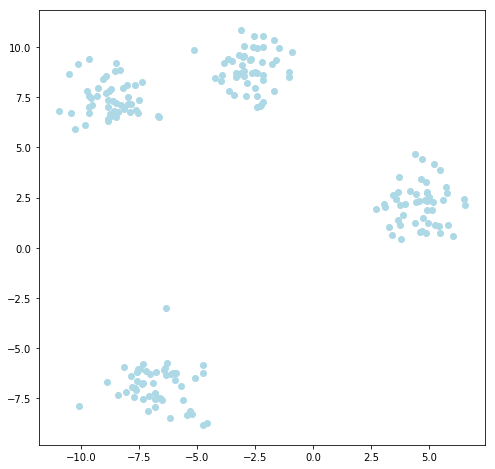

In [4]:
np.random.seed(42)
X, y = make_blobs(200, centers=4, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c='lightblue');

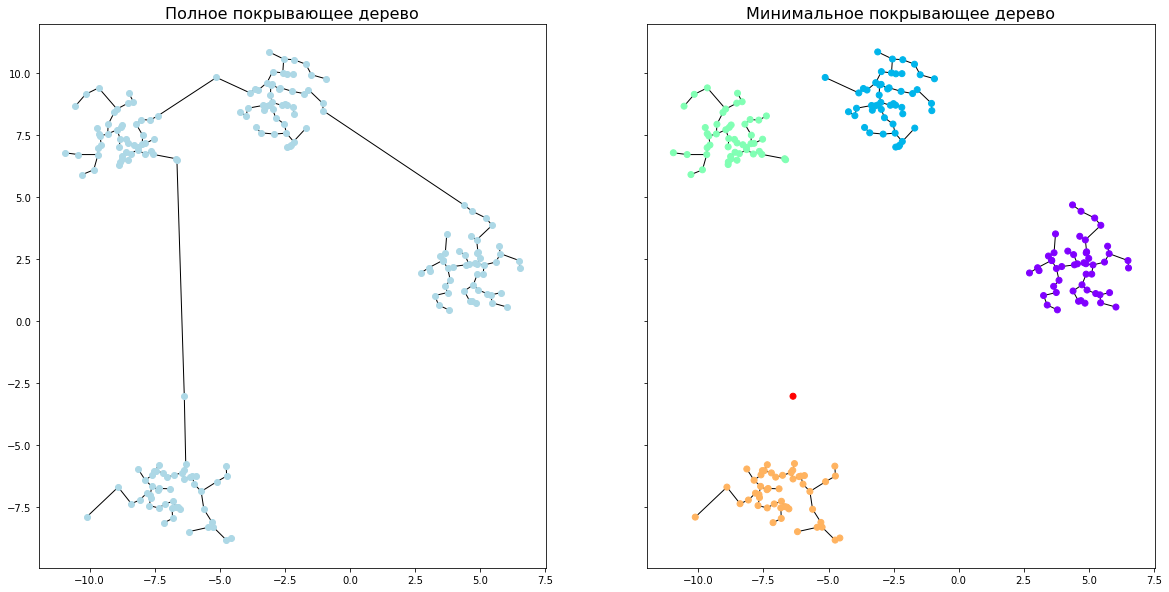

In [5]:
model = MSTClustering(cutoff_scale=2, approximate=False)
labels = model.fit_predict(X)
plot_mst(model)

Посмотрим как алгоритм будет работать на более зашумленных данных.

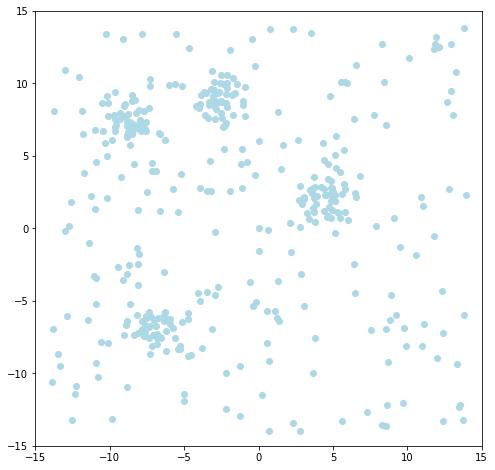

In [6]:
rng = np.random.RandomState(int(100 * y[-1]))
noise = -14 + 28 * rng.rand(200, 2)

X_noisy = np.vstack([X, noise])
y_noisy = np.concatenate([y, np.full(200, -1, dtype=int)])

plt.figure(figsize=(8,8))
plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c='lightblue', cmap='spectral_r')
plt.xlim(-15, 15)
plt.ylim(-15, 15);

In [7]:
def pl(cutoff_scale=1,cutoff=1,min_cluster_size=10):
    noisy_model = MSTClustering(cutoff_scale=cutoff_scale,cutoff=cutoff, min_cluster_size=min_cluster_size)
    noisy_model.fit(X_noisy)
    plot_mst(noisy_model, cmap='spectral_r')

interact(pl, cutoff_scale=(1.0, 8),cutoff=(1,4),min_cluster_size=(2,10));

interactive(children=(FloatSlider(value=1.0, description='cutoff_scale', max=8.0, min=1.0), IntSlider(value=1, description='cutoff', max=4, min=1), IntSlider(value=10, description='min_cluster_size', max=10, min=2), Output()), _dom_classes=('widget-interact',))

**Недостатки**:
- Ограниченная применимость. Наличие разреженного фона или «узких перемычек» между кластерами приводит к неадекватной кластеризации.
- Высокая трудоёмкость — для построения кратчайшего незамкнутого пути требуется $O(l^3)$ операций.


### Алгоритм FOREL (ФОРмальный ЭЛемент)
Предложен Загоруйко и Ёлкиной в 1967 при решении одной прикладной задачи в области палеонтологии.

Пусть задана некоторая точка $_0 \in X$ и параметр $R$. Выделяются все точки выборки $x_i \in X^l$, попадающие внутрь сферы $\rho (x_i, x_0) \leq R$, и точка $x_0$ переносится в центр тяжести выделенных точек. Эта процедура повторяется до тех пор, пока состав выделенных точек, а значит и положение центра, не перестанет меняться.

Доказано, что эта процедура сходится за конечное число шагов. При этом сфера перемещается в место локального сгущения точек. Центр сферы $x_0$ в общем случае не является объектом выборки, потому и называется *формальным элементом*.


**Алгоритм:**

1. Инициализировать множество некластеризованных точек: $U := X^l$;
2. **пока** в выборке есть некластеризованные точки, $U \neq \emptyset$;
3. &nbsp; &nbsp;взять произвольную точку $x_0 \in U$ случайным образом;
4. &nbsp; &nbsp;**повторять**
5. &nbsp; &nbsp;&nbsp; &nbsp;образовать кластер — сферу с центром в $x_0$ и радиусом R: 
 $$K_0 := \{xi \in U \space | \space \rho (x_i, x_0) \leq R\}$$
6. &nbsp; &nbsp;&nbsp; &nbsp;поместить центр сферы в центр масс кластера:
$$x_0 := \dfrac{1}{|K_0|}\sum_{x_i \in K_0}x_i$$
7. &nbsp; &nbsp;**пока** центр $x_0$ не стабилизируется;
8. &nbsp; &nbsp;пометить все точки $K_0$ как кластеризованные:
$$U := U \backslash K_0$$
9. применить алгоритм кратчайшего незамкнутого пути к множеству центров всех найденных кластеров;
10. каждый объект $x_i \in X_l$ приписать кластеру с ближайшим центром;

Существуют задачи, в которых изначально задана только метрика, а сложение и умножение на число не определены на X. Тогда в качестве центра сферы можно взять тот объект обучающей выборки, для которого среднее расстояние до других объектов кластера минимально. Соответственно, шаг 6 заменяется на 
$$_0 := \arg min_{x \in K_0} \sum_{x' \in K_0} \rho(x, x')$$

Преимущество этого алгоритма — возможность описывать кластеры произвольной геометрической формы. Варьируя параметр R, можно получать кластеризации различной степени детальности. Если кластеры близки по форме к шарам, можно сделать R достаточно большим. Для описания кластеров более сложной формы следует уменьшать R.

Алгоритм довольно чувствителен к выбору начального положения точки $x_0$ для каждого нового кластера. Для устранения этого недостатка предлагается генерировать несколько (порядка 10..20) кластеризаций. Поскольку начальное положение центров выбирается случайным образом, эти кластеризации будут довольно сильно отличаться.

## Статистические алгоритмы
Статистические алгоритмы основаны на предположении, что кластеры неплохо описываются некоторым семейством вероятностных распределений. Тогда задача кластеризации сводится к разделению смеси распределений по конечной выборке.

### Метод k-средних (K-means)
Алгоритм К-средних легко представляется в виде простого псевдокода:

- Выбрать количество кластеров k, которое нам кажется оптимальным для наших данных.
- Высыпать случайным образом в пространство наших данных k точек (центроидов).
- Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.
- Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
- Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

В случае обычной евклидовой метрики для точек лежащих на плоскости, этот алгоритм очень просто расписывается аналитически и рисуется.

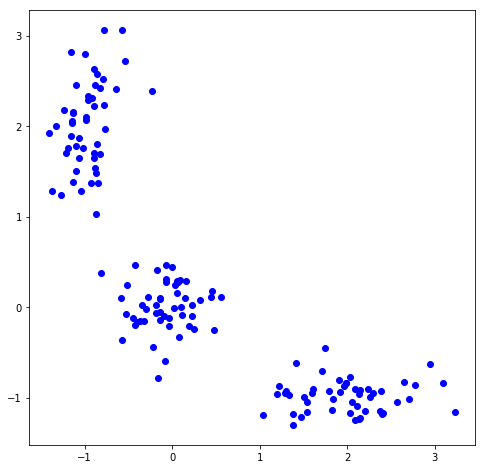

In [8]:
def get_X_m():
    np.random.seed(seed=42)
    X = np.zeros((150, 2))

    X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
    X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

    X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
    X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

    X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
    X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)
    return X

X = get_X_m()

plt.figure(figsize=(8, 8))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [31]:
# Прибьём рандомность и насыпем три случайные центроиды для начала
X = get_X_m()
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)
max_steps=3
for i in range(max_steps):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)
    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

def pl(step=1):
    plt.figure(figsize=(8,8))
    i=step-1
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(step))

In [33]:
interact(pl, step=(1, max_steps));

interactive(children=(IntSlider(value=1, description='step', max=3, min=1), Output()), _dom_classes=('widget-interact',))

Алгоритм чувствителен к исходному положению центроид кластеров в пространстве. В такой ситуации спасает несколько последовательных запусков алгоритма с последующим усреднением полученных кластеров.


Алгоритм k-средних предполагает, что все направления одинаково важны для каждого кластера. Следующий график показывает двумерный набор данных с тремя четко обособленными группами данных. Однако эти группы вытянуты по диагонали.
Поскольку алгоритм k-средних учитывает лишь расстояние до ближайшего центра кластера, он не может обработать данные такого
рода


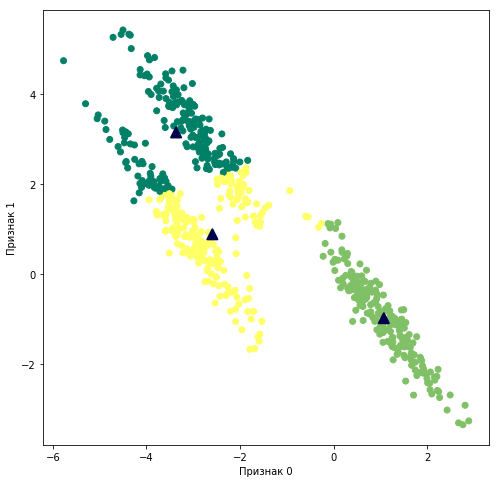

In [10]:
rng = np.random.RandomState(74)
X, y = make_blobs(random_state=170, n_samples=600)

# преобразуем данные так, чтобы они были вытянуты по диагонали
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)
# группируем данные в три кластера
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# строим график принадлежности к кластерам и центров кластеров
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=plt.get_cmap('summer'))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='^', c=[0, 0, 0], s=100, linewidth=2,cmap=plt.get_cmap('seismic') )
plt.xlabel("Признак 0")
plt.ylabel("Признак 1");

Кроме того, алгоритм k-средних плохо работает, когда кластеры имеют более сложную форму или зашумлены.

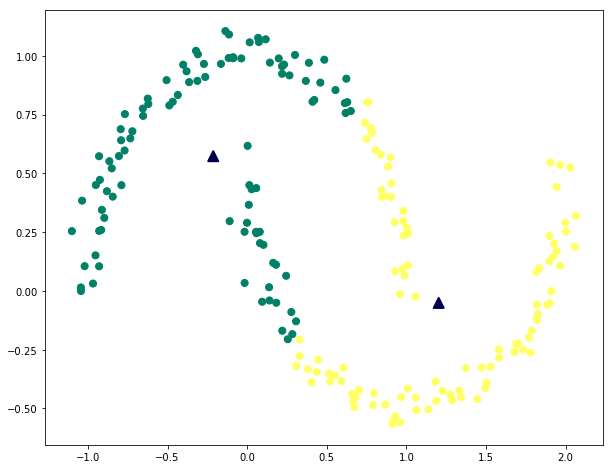

In [11]:
X_moon, y_moon = make_moons(200, noise=.05, random_state=42)
model = KMeans(2, random_state=0)
labels= model.fit_predict(X_moon)
plt.figure(figsize=(10,8))
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='^', c=[0, 0], s=100, linewidth=2,cmap=plt.get_cmap('seismic')) 
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=labels, s=50, cmap=plt.get_cmap('summer'));

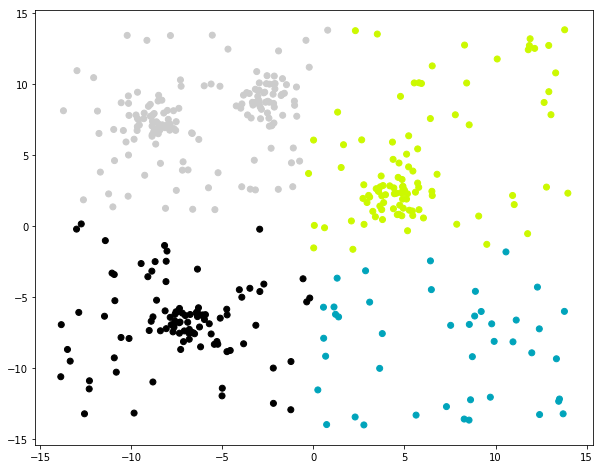

In [40]:
model = KMeans(4, random_state=0)
clusters= model.fit_predict(X_noisy)
plt.figure(figsize=(10,8))
plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c=clusters, cmap='nipy_spectral_r');

### Выбор числа кластеров для kMeans

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$ J(C)=\sum^K_{k=1}\sum_{i \in C_k}||x_i−\mu_k||\rightarrow min_C$$

здесь C – множество кластеров мощности K, $\mu_l$ – центроид кластера $C_k$.


Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки располагались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал J(C) падает "уже не так быстро". Или более формально:


$$D(k)=\frac{|J(C_k)−J(C_{k+1})|}{|J(C_{k−1})−J(C_k)|}\rightarrow min_k$$

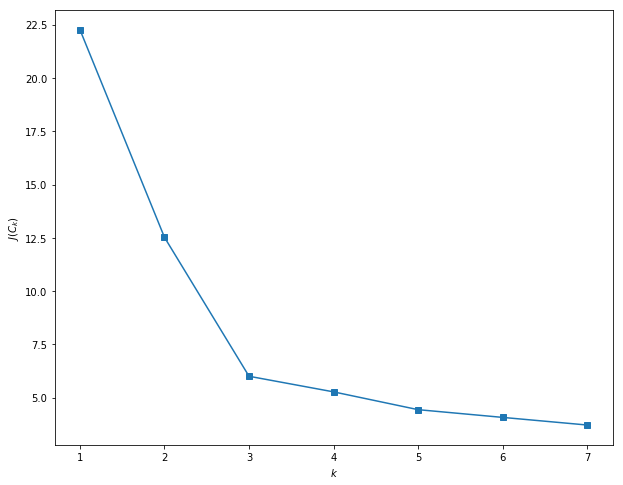

In [41]:
X = get_X_m()
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10,8))
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видим, что $J(C_k)$ падает сильно при увеличении числа кластеров с 1 до 2 и с 2 до 3 и уже не так сильно – при изменении k с 3 до 4. Значит, в данной задаче оптимально задать 3 кластера.

### DBSCAN
DBSCAN (densitybased spatial clustering of applications with noise – плотностный алгоритм кластеризации пространственных данных с присутствием шума). 
Основные преимущества алгоритма DBSCAN заключаются в том, что пользователю не нужно заранее задавать количество кластеров, алгоритм может выделить кластеры сложной формы и способен определить точки, которые не принадлежат какому-либо кластеру. 

DBSCAN работает немного медленнее, чем алгоритм агломеративной кластеризации и алгоритм k-средних, но также может масштабироваться на относительно большие наборы данных.


DBSCAN определяет точки, расположенные в «густонаселенных» областях пространства характеристик, когда многие точки данных расположены близко друг к другу. Эти области называются плотными (dense) областями пространства характеристик. 

Точки, находящиеся в плотной области, называются ядровыми примерами (core samples) или ядровыми точками (core points). Алгоритм DBSCAN имеет два параметра: **min_samples** и **eps**. Если по крайней мере min_samples точек находятся в радиусе окрестности eps рассматриваемой точки, то эта точка классифицируется как ядровая. Ядровые точки, расстояния между которыми не превышают радиус окрестности eps, помещаются алгоритмом DBSCAN в один и тот же кластер.

In [34]:
def plot_dbscan():
    X, y = make_blobs(random_state=0, n_samples=12)

    dbscan = DBSCAN()
    clusters = dbscan.fit_predict(X)
    clusters

    fig, axes = plt.subplots(3, 4, figsize=(11, 8),
                             subplot_kw={'xticks': (), 'yticks': ()})
    # Plot clusters as red, green and blue, and outliers (-1) as white
    colors = [mglearn.cm3(1), mglearn.cm3(0), mglearn.cm3(2)]
    markers = ['o', '^', 'v']

    # iterate over settings of min_samples and eps
    for i, min_samples in enumerate([2, 3, 5]):
        for j, eps in enumerate([1, 1.5, 2, 3]):
            # instantiate DBSCAN with a particular setting
            dbscan = DBSCAN(min_samples=min_samples, eps=eps)
            # get cluster assignments
            clusters = dbscan.fit_predict(X)
#             print("min_samples: %d eps: %f  cluster: %s"
#                   % (min_samples, eps, clusters))
            if np.any(clusters == -1):
                c = ['w'] + colors
                m = ['o'] + markers
            else:
                c = colors
                m = markers
            mglearn.discrete_scatter(X[:, 0], X[:, 1], clusters, ax=axes[i, j], c=c,
                             s=8, markers=m)
            inds = dbscan.core_sample_indices_
            # vizualize core samples and clusters.
            if len(inds):
                mglearn.discrete_scatter(X[inds, 0], X[inds, 1], clusters[inds],
                                 ax=axes[i, j], s=15, c=colors,
                                 markers=markers)
            axes[i, j].set_title("min_samples: %d eps: %.1f"
                                 % (min_samples, eps))
    fig.tight_layout()


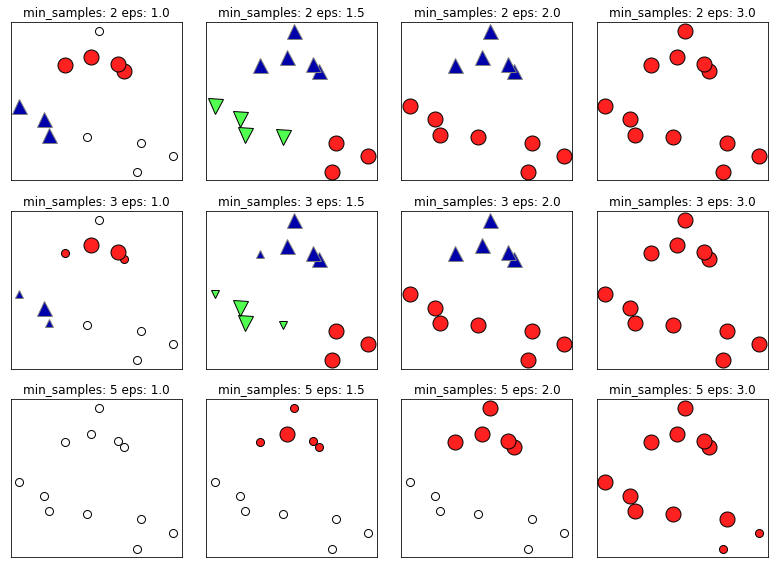

In [35]:
plot_dbscan()

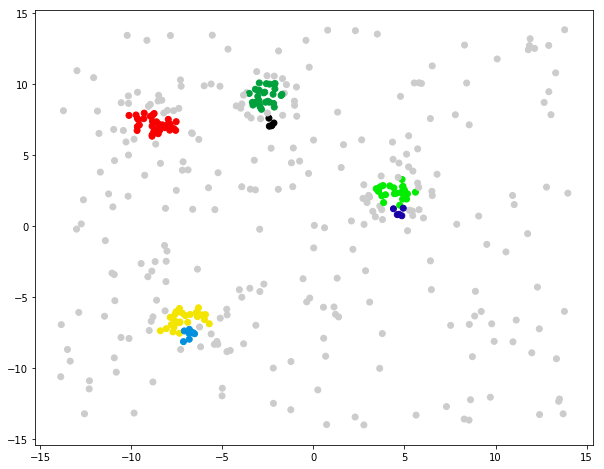

In [42]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_noisy)
plt.figure(figsize=(10,8))
plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c=clusters, cmap='nipy_spectral_r');

Несмотря на то что в алгоритме DBSCAN не нужно явно указывать количество кластеров, значение **eps** неявно задает количество выделяемых кластеров. Иногда подобрать оптимальное значение **eps** становится проще после масштабирования данных с помощью StandardScaler или MinMaxScaler, так как использование этих методов масштабирования гарантирует, что все характеристики будут иметь одинаковый масштаб.

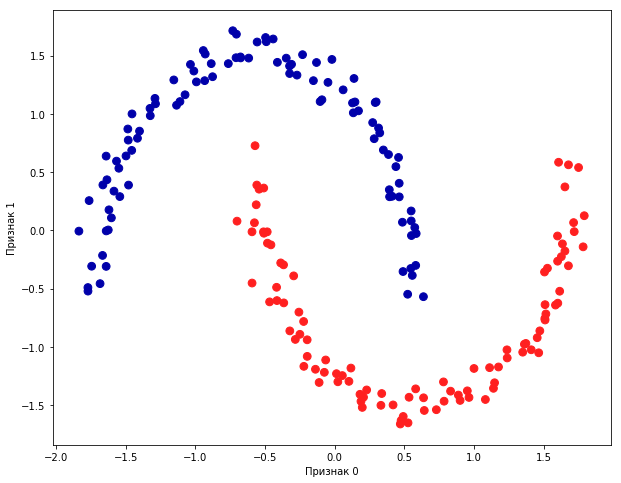

In [43]:
# масштабируем данные так, чтобы получить нулевое среднее и единичную дисперсию
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_moon)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
# выводим принадлежность к кластерам
plt.figure(figsize=(10,8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Признак 0")
plt.ylabel("Признак 1");

## Иерархическая кластеризация
Иерархические алгоритмы кластеризации, называемые также алгоритмами таксономии, строят не одно разбиение выборки на непересекающиеся классы, а систему вложенных разбиений. 

Результат таксономии обычно представляется в виде таксономического дерева — дендрограммы. Классическим примером такого дерева является иерархическая классификация животных и растений.
Среди алгоритмов иерархической кластеризации различаются два основных типа: 
- Дивизимные или нисходящие алгоритмы разбивают выборку на всё более и более мелкие кластеры. 
- Более распространены агломеративные или восходящие алгоритмы, в которых объекты объединяются во всё более и более крупные кластеры.

### Агломеративные методы
Интуиция у алгоритма очень простая:

- Начинаем с того, что высыпаем на каждую точку свой кластер
- Сортируем попарные расстояния между центрами кластеров по возрастанию
- Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
- Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

Результатом агломеративной кластеризации является иерархическая кластеризация (hierarchical clustering). Кластеризация выполняется итеративно, и каждая точка совершает путь от отдельной точки-кластера до участника итогового кластера. На каждом промежуточном шаге происходит кластеризация данных (с разным количеством кластеров).

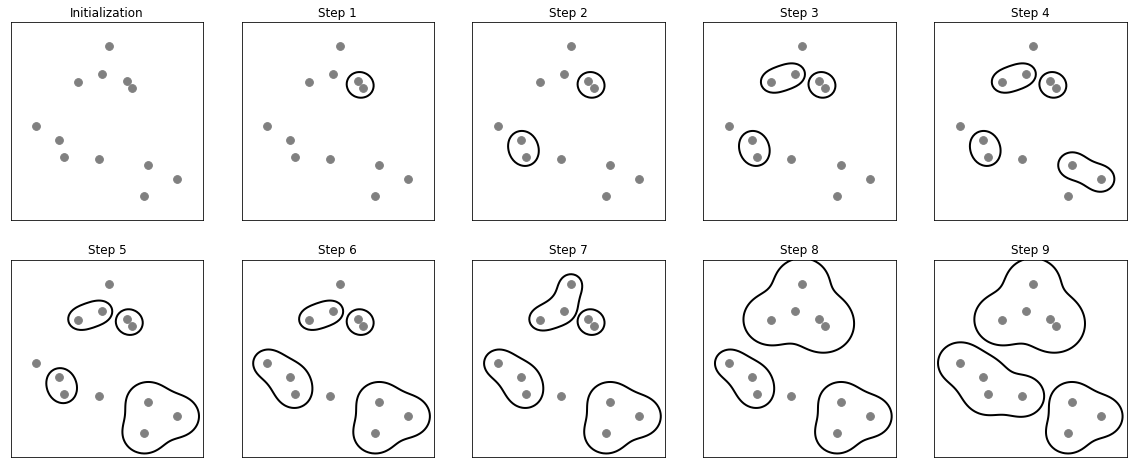

In [15]:
mglearn.plots.plot_agglomerative_algorithm()

### Иерархические дивизимные (делимые) методы 
Эти методы являются логической противоположностью агломеративным методам. Вначале работы алгоритма все объекты принадлежат одному кластеру, который на последующих шагах делится на меньшие кластеры, в результате образуется последовательность расщепляющих групп.

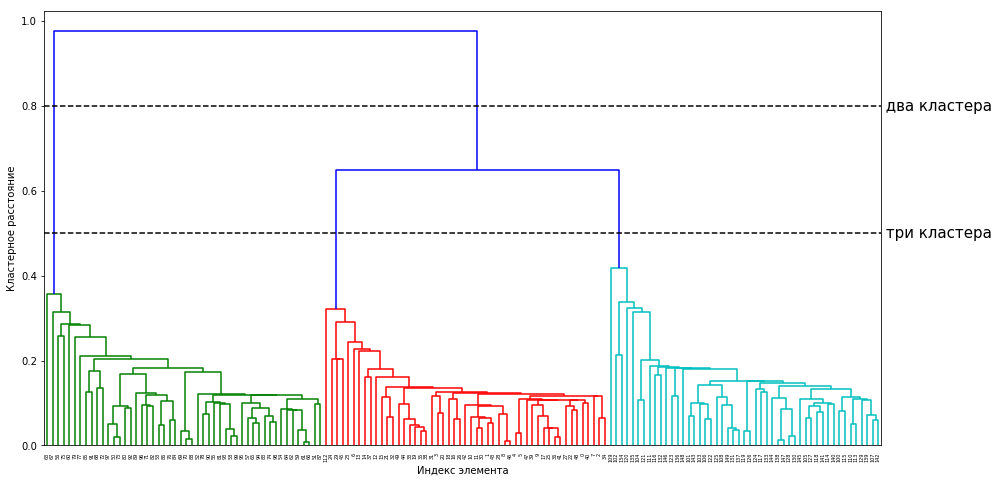

In [16]:
X = get_X_m()
distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
_, ax = plt.subplots(1,1, figsize=(15, 8))
plt.xlabel("Индекс элемента")
plt.ylabel("Кластерное расстояние")

dn = hierarchy.dendrogram(Z, color_threshold=0.5,ax=ax);
bounds = ax.get_xbound()
ax.plot(bounds, [.5, .5], '--', c='k')
ax.plot(bounds, [.8, .8], '--', c='k')
ax.text(bounds[1], .8, ' два кластера', va='center', fontdict={'size': 15})
ax.text(bounds[1], .5, ' три кластера', va='center', fontdict={'size': 15});

Отличный ресурс с объяснением и визуализацией работы алгоритмов класстеризации: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

# Метрики качества кластеризации
Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Во-первых, такие оценки не должны зависеть от самих значений меток, а только от самого разбиения выборки. Во-вторых, не всегда известны истинные метки объектов, поэтому также нужны оценки, позволяющие оценить качество кластеризации, используя только неразмеченную выборку.


In [17]:
# эти две маркировки точек соответствуют одним и тем же результатам кластеризации
# в clusters1 записаны фактические результаты кластеризации,
# а в clusters2 записаны расчетные результаты кластеризации
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# правильность равна нулю, поскольку ни одна из присвоенных меток не отражает
# истинную кластеризацию
print("размеченые кластеры: {:>18}\nпредсказанные кластеры: {}".format(str(clusters1),clusters2))
print("Правильность: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# значение скорр. коэффициента Рэнда равно 1, поскольку полученные результаты
# точно воспроизводят истинную кластеризацию
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

размеченые кластеры:    [0, 0, 1, 1, 0]
предсказанные кластеры: [1, 1, 0, 0, 1]
Правильность: 0.00
ARI: 1.00


Выделяют внешние и внутренние метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.

### Adjusted Rand Index (ARI)
Предполагается, что известны истинные метки объектов. Данная мера не зависит от самих значений меток, а только от разбиения выборки на кластеры. Пусть n — число объектов в выборке. Обозначим через a — число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через b — число пар объектов, имеющих различные метки и находящихся в разных кластерах. Тогда Rand Index это

$$RI=\frac{2(a+b)}{n(n−1)}$$

То есть это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Rand Index (RI) выражает схожесть двух разных кластеризаций одной и той же выборки. Чтобы этот индекс давал значения близкие к нулю для случайных кластеризаций при любом n и числе кластеров, необходимо нормировать его. Так определяется Adjusted Rand Index:
$$ARI=\frac{RI−E[RI]}{max(RI)−E[RI]}$$


Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки. ARI принимает значения в диапазоне [−1,1]. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, — случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при ARI=1).

### Adjusted Mutual Information (AMI)


Данная мера очень похожа на ARI. Она также симметрична, не зависит от значений и перестановок меток. Определяется с использованием функции энтропии, интерпретируя разбиения выборки, как дискретные распределения (вероятность отнесения к кластеру равна доле объектов в нём). Индекс MI определяется как взаимная информация для двух распределений, соответствующих разбиениям выборки на кластеры. Интуитивно, взаимная информация измеряет долю информации, общей для обоих разбиений: насколько информация об одном из них уменьшает неопределенность относительно другого.


Аналогично ARI определяется индекс AMI, позволяющий избавиться от роста индекса MI с увеличением числа классов. Он принимает значения в диапазоне [0,1]. Значения, близкие к нулю, говорят о независимости разбиений, а близкие к единице – об их схожести (совпадении при AMI=1).

### Гомогенность, полнота, V-мера


Формально данные меры также определяются с использованием функций энтропии и условной энтропии, рассматривая разбиения выборки как дискретные распределения:

$$h=1−\frac{H(C∣K)}{H(C)},c=1−\frac{H(K∣C)}{H(K)}$$

здесь K — результат кластеризации, C — истинное разбиение выборки на классы. Таким образом, h измеряет, насколько каждый кластер состоит из объектов одного класса, а c — насколько объекты одного класса относятся к одному кластеру. Эти меры не являются симметричными. Обе величины принимают значения в диапазоне [0,1], и большие значения соответствуют более точной кластеризации. Эти меры не являются нормализованными, как ARI или AMI, и поэтому зависят от числа кластеров. Случайная кластеризация не будет давать нулевые показатели при большом числе классов и малом числе объектов. В этих случаях предпочтительнее использовать ARI. Однако при числе объектов более 1000 и числе кластеров менее 10 данная проблема не так явно выражена и может быть проигнорирована.
Для учёта обеих величин h и c одновременно вводится V-мера, как их среднее гармоническое:


$$\nu=2\frac{hc}{h+c}$$.

Она является симметричной и показывает, насколько две кластеризации схожи между собой.

### Силуэт
В отличие от описанных выше метрик, данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Сначала силуэт определяется отдельно для каждого объекта. Обозначим через a — среднее расстояние от данного объекта до объектов из того же кластера, через b — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина:

$$s=\frac{b−a}{max(a,b)}.$$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне [−1,1]. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

In [49]:
metrics={"ARI": adjusted_rand_score,"V-measure":v_measure_score,"Silhouette":silhouette_score}
def plot_acc(metric_name="ARI"):
    
    X_moon, y_moon = make_moons(n_samples=200, noise=0.05, random_state=0)
    # масштабируем данные так, чтобы получить нулевое среднее и единичную дисперсию
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_moon)
    fig, axes = plt.subplots(1, 4, figsize=(18, 5), subplot_kw={'xticks': (), 'yticks': ()})

    # создаем список используемых алгоритмов
    algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

    # случайно присваиваем точки двум кластерам для сравнения
    random_state = np.random.RandomState(seed=0)
    random_clusters = random_state.randint(low=0, high=2, size=len(X_moon))

    # выводим на графике результаты случайного присвоения кластеров
    axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
    if metric_name is 'Silhouette':
        axes[0].set_title("Случайное присвоение - {}: {:.2f}".format(metric_name, metrics[metric_name](X_scaled, random_clusters)))
    else:
        axes[0].set_title("Случайное присвоение - {}: {:.2f}".format(metric_name, metrics[metric_name](y_moon, random_clusters)))

    for ax, algorithm in zip(axes[1:], algorithms):
        # выводим на графике принадлежность к кластерам и центры кластеров
        clusters = algorithm.fit_predict(X_scaled)
        ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
        if metric_name is 'Silhouette':
            ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__,metric_name, metrics[metric_name](X_scaled, clusters)))
        else:
            ax.set_title("{} - {}: {:.2f}".format(algorithm.__class__.__name__,metric_name, metrics[metric_name](y_moon, clusters)))

In [50]:
interact(plot_acc, metric_name=list(metrics));

interactive(children=(Dropdown(description='metric_name', options=('ARI', 'V-measure', 'Silhouette'), value='ARI'), Output()), _dom_classes=('widget-interact',))

# Анализ главных компонент (PCA- principal component analysis)
Анализ главных компонент представляет собой метод, который осуществляет вращение данных с тем, чтобы преобразованные признаки не коррелировали между собой. Часто это вращение сопровождается выбором подмножества новых признаков в зависимости от их важности с точки зрения интерпретации данных. 


In [38]:
def plot_pca_illustration():
    rnd = np.random.RandomState(5)
    X_ = rnd.normal(size=(300, 2))
    X_blob = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2)

    pca = PCA()
    pca.fit(X_blob)
    X_pca = pca.transform(X_blob)

    S = X_pca.std(axis=0)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    axes[0].set_title("Исходные данные")
    axes[0].scatter(X_blob[:, 0], X_blob[:, 1], c=X_pca[:, 0], linewidths=0, s=60, cmap='viridis')
    axes[0].set_xlabel("признак 1")
    axes[0].set_ylabel("признак 2")
    axes[0].arrow(pca.mean_[0], pca.mean_[1], S[0] * pca.components_[0, 0],
                  S[0] * pca.components_[0, 1], width=.1, head_width=.3,
                  color='k')
    axes[0].arrow(pca.mean_[0], pca.mean_[1], S[1] * pca.components_[1, 0],
                  S[1] * pca.components_[1, 1], width=.1, head_width=.3,
                  color='k')
    axes[0].text(-1.5, -.5, "Component 2", size=14)
    axes[0].text(-4, -4, "Component 1", size=14)
    axes[0].set_aspect('equal')

    axes[1].set_title("Преобразованные данные ")
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=X_pca[:, 0], linewidths=0,
                    s=60, cmap='viridis')
    axes[1].set_xlabel("Первая главная компонента")
    axes[1].set_ylabel("Вторая главная компонента")
    axes[1].set_aspect('equal')
    axes[1].set_ylim(-8, 8)

    pca = PCA(n_components=1)
    pca.fit(X_blob)
    X_inverse = pca.inverse_transform(pca.transform(X_blob))

    axes[2].set_title("Преобразованные данные с удаленной второй компонентой")
    axes[2].scatter(X_pca[:, 0], np.zeros(X_pca.shape[0]), c=X_pca[:, 0],
                    linewidths=0, s=60, cmap='viridis')
    axes[2].set_xlabel("Первая главная компонента")
    axes[2].set_aspect('equal')
    axes[2].set_ylim(-8, 8)

    axes[3].set_title("Обратное вращение с использование только первой компоненты")
    axes[3].scatter(X_inverse[:, 0], X_inverse[:, 1], c=X_pca[:, 0],
                    linewidths=0, s=60, cmap='viridis')
    axes[3].set_xlabel("признак 1")
    axes[3].set_ylabel("признак 2")
    axes[3].set_aspect('equal')
    axes[3].set_xlim(-8, 4)
    axes[3].set_ylim(-8, 4)

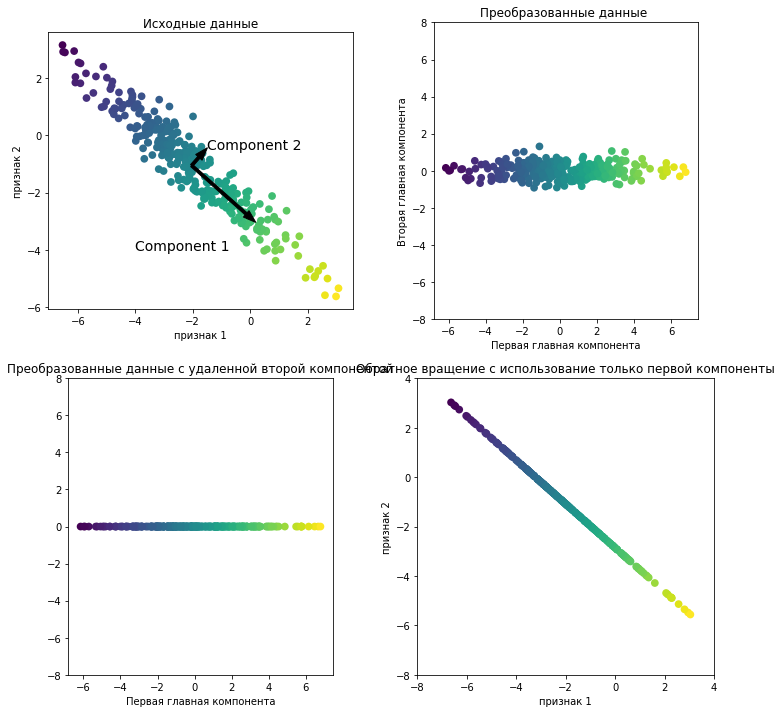

In [39]:
plot_pca_illustration() 

Первый рис. (вверху слева) показывает исходные точки данных. Алгоритм начинает работу с того, что сначала находит направление максимальной дисперсии, помеченное как «компонента 1». Речь идет о направлении (или векторе) данных, который содержит большую часть информации, или другими словами, направление, вдоль которого признаки коррелируют друг с другом сильнее всего. 

Затем алгоритм находит направление, которое содержит наибольшее количество информации, и при этом ортогонально (расположено под прямым углом) первому направлению. В двумерном пространстве существует только одна возможная ориентация, расположенная под прямым углом, но в пространствах большей размерности может быть (бесконечно) много ортогональных направлений. Хотя эти две компоненты изображаются в виде стрелок, на самом деле не имеет значения, где начало, а где конец, мы могли бы нарисовать первую компоненту, выходящую из центра в верхний левый угол, а не в нижний правый. 
Направления, найденные с помощью этого алгоритма, называются главными компонентами (principal components), поскольку они являются основными направлениями дисперсии данных. 

Второй график (вверху справа) показывает те же самые данные, но теперь повернутые таким образом, что первая главная компонента совпадает с осью х, а вторая главная компонента совпадает с осью у. Перед вращением из каждого значения данных вычитается среднее, таким образом, преобразованные данные центрированы около нуля. В новом представлении данных, найденном с помощью PCA, две оси становятся некоррелированными. Это означает, что в новом представлении все элементы корреляционной матрицы данных, кроме диагональных, будут равны нулю.

Мы можем оставить лишь первую главную компоненту, как показано на третьем  графике. Это уменьшит размерность данных: из
двумерного массива данных получаем одномерный массив данных. 

Мы можем отменить вращение и добавить обратно среднее значение к значениям данных. В итоге получим данные, показанные на последнем графике . Эти точки располагаются в пространстве исходных признаков, но мы оставили лишь информацию, содержащуюся
в первой главной компоненте.


Рассмотрим как это делается математически:

Чтобы снизить размерность наших данных из n в k, $k\leq n$, нам нужно выбрать топ-k осей такого эллипсоида, отсортированные по убыванию по дисперсии вдоль осей.

Начнём с того, что посчитаем дисперсии и ковариации исходных признаков. Это делается просто с помощью матрицы ковариации. По определению ковариации, для двух признаков $X_i$ и $X_j$ их ковариация будет


$$cov(X_i,X_j)=E[(X_i−\mu_i)(X_j−\mu_j)]=E[X_iX_j]−\mu_i\mu_j$$

где $\mu_i$ — матожидание i-ого признака.
При этом отметим, что ковариация симметрична и ковариация вектора с самим собой будет равна его дисперсии.


Таким образом матрица ковариации представляет собой симметричную матрицу, где на диагонали лежат дисперсии соответствующих признаков, а вне диагонали — ковариации соответствующих пар признаков. В матричном виде, где X это матрица наблюдений, наша матрица ковариации будет выглядеть как


$$\sum=E[(X−E[X])(X−E[X])^T]$$

Чтобы освежить память — у матриц как у линейных операторов есть такое интересное свойство как собственные значения и собственные вектора (eigenvalues и eigenvectors). 
Эти штуки замечательны тем, что когда мы нашей матрицей действуем на соответствующее линейное пространство, собственные вектора остаются на месте и лишь умножаются на соответствующие им собственные значения. То есть определяют подпространство, которое при действии этой матрицей как линейным оператором, остаётся на месте или "переходит в себя". Формально собственный вектор $w_i$ с собственным значением $\lambda_i$ для матрицы M определяется просто как $M\omega_i=\lambda_i\omega_i$.

Дальнейшие шаги просты до безобразия — надо просто умножить нашу матрицу данных на эти компоненты и мы получим проекцию наших данных в ортогональном базисе этих компонент. Теперь если мы транспонируем нашу матрицу данных и матрицу векторов главных компонент, мы восстановим исходную выборку в том пространстве, из которого мы делали проекцию на компоненты. Если количество компонент было меньше размерности исходного пространства, мы потеряем часть информации при таком преобразовании.

In [41]:
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# Загрузим наши ириски
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

def plot_iris():
    # Заведём красивую трёхмерную картинку
    fig = plt.figure(1, figsize=(6, 5))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()

    for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
        ax.text3D(X_iris[y_iris == label, 0].mean(),
              X_iris[y_iris == label, 1].mean() + 1.5,
              X_iris[y_iris == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    # Поменяем порядок цветов меток, чтобы они соответствовали правильному
    y_clr = np.choose(y_iris, [1, 2, 0]).astype(np.float)
    ax.scatter(X_iris[:, 0], X_iris[:, 1], X_iris[:, 2], c=y_clr, cmap='viridis')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([]);

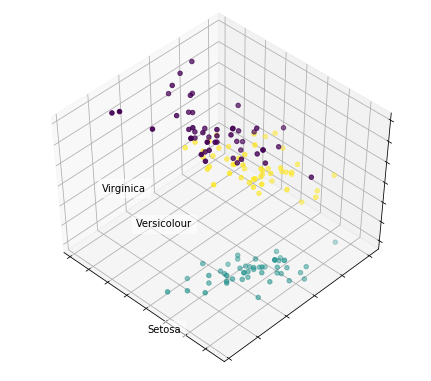

In [42]:
plot_iris()

Теперь посмотрим, насколько PCA улучшит результаты для модели

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

def scoreModel(X,y):
    # Выделим из наших данных валидационную выборку
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y_iris,  random_state=42)

    # Для примера возьмём неглубокое дерево решений
    clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.88889


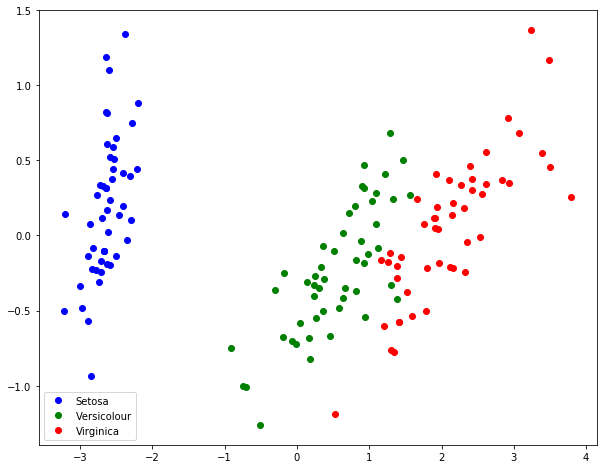

In [51]:
pca = PCA(n_components=2)
X_centered = X_iris - X_iris.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

plt.figure(figsize=(10,8))
# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y_iris == 0, 0], X_pca[y_iris == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y_iris == 1, 0], X_pca[y_iris == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y_iris == 2, 0], X_pca[y_iris == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [44]:
print("До pca")
scoreModel(X_iris,y_iris)
print("После")
scoreModel(X_pca,y_iris)

До pca
Accuracy: 0.88889
После
Accuracy: 0.91111


Важно отметить, что РСА является методом машинного обучения без учителя и не использует какой-либо информации о классах при поиске поворота. Он просто анализирует корреляционные связи в данных. Для точечного графика, показанного здесь, мы построили график, где по оси x отложена первая главная компонента, по оси y – вторая главная компонента, а затем воспользовались информацией о классах, чтобы выделить точки разным цветом. 

Еще одно применение PCA, о котором мы уже упоминали ранее, – это выделение признаков. Идея, лежащая в основе выделения признаков, заключается в поиске нового представления данных, которое в отличие от исходного лучше подходит для анализа. Отличный пример, показывающий, что выделение признаков может быть полезно, – это работа с изображениями. 

Мы приведем очень простой пример того, как можно применить выделение признаков к изображениям с помощью PCA. Для этого мы воспользуемся набором данных Labeled Faces in the Wild. 

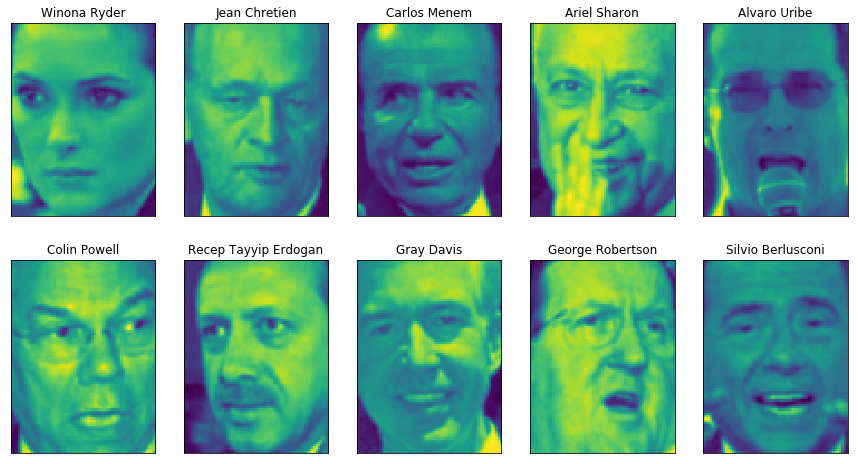

In [24]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape
fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [25]:
print("форма массива изображений лиц: {}".format(people.images.shape))
print("количество классов: {}".format(len(people.target_names)))


форма массива изображений лиц: (3023, 87, 65)
количество классов: 62


In [26]:
'''
Чтобы данные стали менее асимметричными, мы будем рассматривать
не более 50 изображений каждого человека (в противном случае
выделение признаков будет перегружено большим количеством
изображений Джорджа Буша)
'''
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
# для получения большей стабильности масштабируем шкалу оттенков серого так, чтобы значения
# были в диапазоне от 0 до 1 вместо использования шкалы значений от 0 до 255
X_people = X_people / 255.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
# print("обучающие данные до PCA: {}".format(X_people.shape[0]))
# print("обучающие данные после PCA: {}".format(X_train_pca.shape[0]))

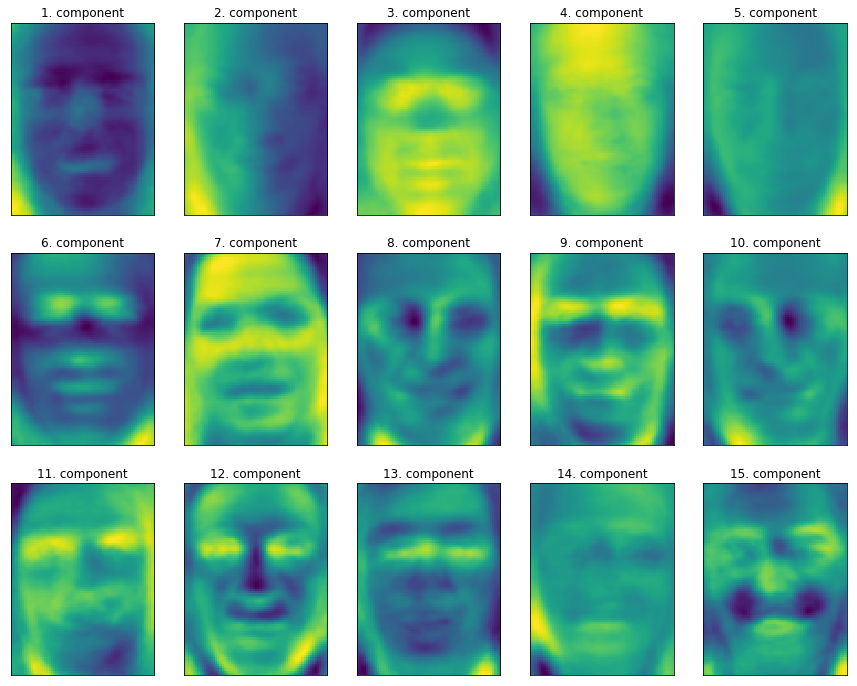

In [80]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))


одна из полезных интерпретаций PCA заключается в том, чтобы попытаться вычислить значения новых признаков, полученные после
поворота PCA, таким образом, мы можем записать тестовые точки в виде взвешенной суммы главных компонент.

![](../../img/lesson10/pca.JPG)

Здесь $x_1$,$x_2$ и т.д. являются коэффициентами главных компонент для конкретной точки данных, другими словами, они представляют собой изображение в новом пространстве, полученном в результате вращения.

В начале темы про PCA на графике мы удалили вторую компоненту, затем мы отменили вращение и добавили обратно среднее значение, чтобы получить новые точки в исходном пространстве с удаленной второй компонентой, как показано на последнем графике.

Мы можем выполнить аналогичное преобразование для лиц, сократив данные за счет использования лишь некоторых главных компонент и вернувшись затем в исходное пространство. Здесь мы визуализируем результаты реконструкции некоторых лиц,
используя 10, 50, 100, 500 и 2000 компонент.

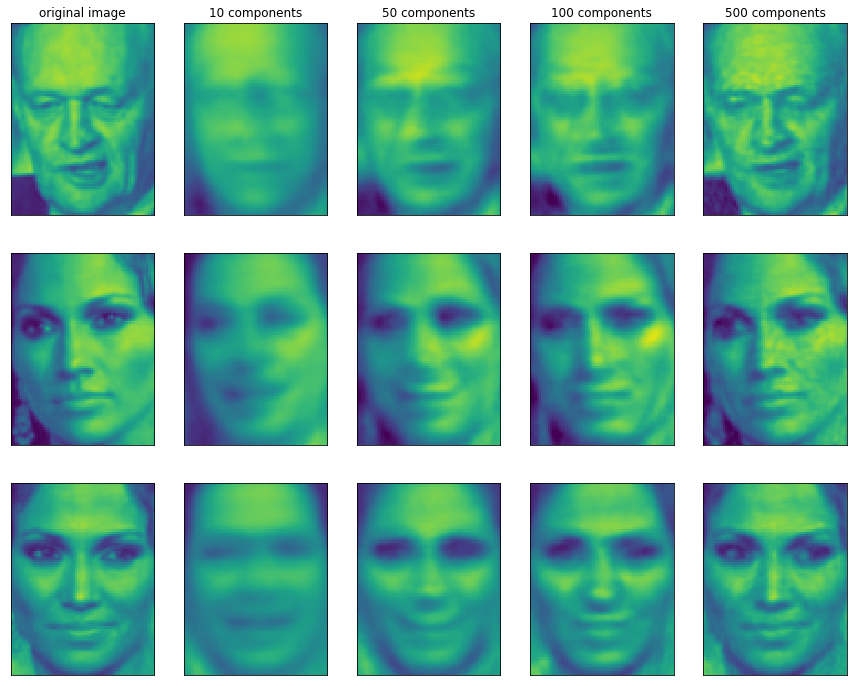

In [29]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

**Сколько же главных компонент нужно выбрать?**
На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных.
В данном случае для этого достаточно выделить 105 главную компоненту.

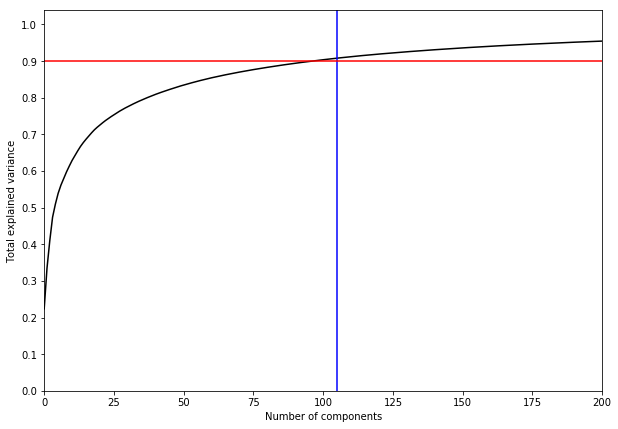

In [30]:
pca = PCA().fit(X_train)
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(105, c='b')
plt.axhline(0.9, c='r')
plt.show();

-----

## Источники

- [machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)
- [Лекции Воронцова К. В.](http://www.ccas.ru/voron/download/Clustering.pdf)
- [Обзор алгоритмов кластеризации данных](https://habrahabr.ru/post/101338/)
- [Открытый курс машинного обучения. Тема 7. Обучение без учителя: PCA  и кластеризация]( https://habrahabr.ru/company/ods/blog/325654/)
- [Как работает метод главных компонент (PCA) на простом примере](https://habrahabr.ru/post/304214/)
- [Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными](https://www.ozon.ru/context/detail/id/140891479/)